<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/master/songLyricsGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf 

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2020-08-12 14:21:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-08-12 14:21:52 (123 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [3]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split('\n')

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [4]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [5]:
input_sequences

[[51, 12],
 [51, 12, 96],
 [51, 12, 96, 1217],
 [51, 12, 96, 1217, 48],
 [51, 12, 96, 1217, 48, 2],
 [51, 12, 96, 1217, 48, 2, 69],
 [2, 11],
 [2, 11, 15],
 [2, 11, 15, 31],
 [2, 11, 15, 31, 361],
 [2, 11, 15, 31, 361, 8],
 [2, 11, 15, 31, 361, 8, 24],
 [2, 11, 15, 31, 361, 8, 24, 1218],
 [272, 798],
 [272, 798, 2],
 [272, 798, 2, 204],
 [272, 798, 2, 204, 24],
 [272, 798, 2, 204, 24, 579],
 [272, 798, 2, 204, 24, 579, 69],
 [118, 35],
 [118, 35, 119],
 [118, 35, 119, 799],
 [118, 35, 119, 799, 56],
 [118, 35, 119, 799, 56, 24],
 [118, 35, 119, 799, 56, 24, 184],
 [10, 184],
 [10, 184, 25],
 [10, 184, 25, 23],
 [10, 184, 25, 23, 5],
 [10, 184, 25, 23, 5, 580],
 [10, 184, 25, 23, 5, 580, 456],
 [2, 184],
 [2, 184, 800],
 [2, 184, 800, 12],
 [2, 184, 800, 12, 801],
 [2, 184, 800, 12, 801, 4],
 [2, 184, 800, 12, 801, 4, 7],
 [2, 184, 800, 12, 801, 4, 7, 235],
 [1219, 17],
 [1219, 17, 12],
 [1219, 17, 12, 75],
 [1219, 17, 12, 75, 1220],
 [1219, 17, 12, 75, 1220, 236],
 [1219, 17, 12, 75, 1

In [6]:
max_sequence_len = max([len(x) for x in input_sequences])

In [7]:
max_sequence_len

16

In [8]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [9]:
input_sequences

array([[   0,    0,    0, ...,    0,   51,   12],
       [   0,    0,    0, ...,   51,   12,   96],
       [   0,    0,    0, ...,   12,   96, 1217],
       ...,
       [   0,    0,    0, ...,    0,   47,  105],
       [   0,    0,    0, ...,   47,  105,  138],
       [   0,    0,    0, ...,  105,  138,  184]], dtype=int32)

In [10]:
input_sequences.shape

(12038, 16)

CREATE PREDICTORS AND LABELS

In [11]:
xs, labels = input_sequences[:,:-1], input_sequences[:, -1]

In [12]:
labels

array([  12,   96, 1217, ...,  105,  138,  184], dtype=int32)

In [13]:
labels.shape

(12038,)

In [14]:
xs.shape

(12038, 15)

In [16]:
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [19]:
ys[0].shape

(2690,)

In [20]:
print(xs[5])
print(ys[5])

[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
[0. 0. 0. ... 0. 0. 0.]


In [21]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))#we are predicting the probability of generating a word from the corpus
adam =Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
print(model)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           269000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 2690)              809690    
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(xs, ys, epochs=100, verbose=1)

Epoch 1/100
377/377 [==============================] - 4s 9ms/step - loss: 6.6596 - accuracy: 0.0755
Epoch 2/100
377/377 [==============================] - 3s 9ms/step - loss: 5.7987 - accuracy: 0.1111
Epoch 3/100
377/377 [==============================] - 4s 9ms/step - loss: 4.9493 - accuracy: 0.1575
Epoch 4/100
377/377 [==============================] - 3s 9ms/step - loss: 4.0967 - accuracy: 0.2251
Epoch 5/100
377/377 [==============================] - 3s 9ms/step - loss: 3.2344 - accuracy: 0.3245
Epoch 6/100
377/377 [==============================] - 4s 10ms/step - loss: 2.5741 - accuracy: 0.4247
Epoch 7/100
377/377 [==============================] - 3s 9ms/step - loss: 2.0605 - accuracy: 0.5214
Epoch 8/100
377/377 [==============================] - 4s 10ms/step - loss: 1.7291 - accuracy: 0.5891
Epoch 9/100
377/377 [==============================] - 4s 10ms/step - loss: 1.4971 - accuracy: 0.6370
Epoch 10/100
377/377 [==============================] - 3s 9ms/step - loss: 1.2452 - acc

In [25]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

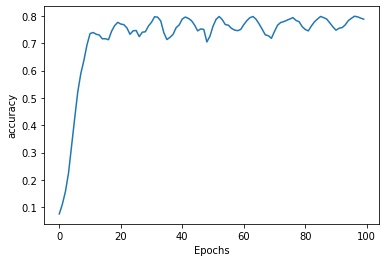

In [26]:
plot_graphs(history, 'accuracy')

In [27]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
I've got a bad feeling about this fathers rigadoo and gone and the covers buttoned through gone love gone my love love love gone love had gone love love love my loves love him love gone love love him gone love me gone alone love love left old thee came me heartfrom sinking easy as gone night im going up wexford love gone love me love and me heartfrom sinking easy sinking give me more bravely gone when gone gone you love love me love me more love love love love so dearly love me gone oer gone love had love love love love love love love
